In [14]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions, predict_future
from dataset import transform_data
from copy import deepcopy

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

import sklearn.metrics
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

num_layers = 3
hidden_size = 32
region = "germany"
epochs = 20
include_time = True

model_dir="/data2/igarss2020/tune/"
log_dir = "/data2/igarss2020/tune/"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}"
log_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_log.csv"


In [19]:
#!ls /data2/igarss2020/tune/*.csv
log_dir="/data2/igarss2020/tune/"
csv_files = [f for f in os.listdir(log_dir) if f.endswith('csv')] 

mins = list()
for csv in csv_files:
    pth = os.path.join(log_dir,csv)
    series=pd.read_csv(pth).sort_values(by="mse",ascending=True).iloc[0]
    series.name=csv
    mins.append(series)
    
df = pd.DataFrame(mins).sort_values(by="mse",ascending=True).iloc[:5]
df
#pd.read_csv("/data2/igarss2020/tune/LSTM_germany_l=1_h=32_log.csv").min()

,Unnamed: 0,epoch,mae,mse,rmse,trainloss,testloss
LSTM_germany_l=1_h=128_lr=0.001_weightdecay=1e-05_log.csv,4.0,4.0,0.582890,0.554066,0.744356,0.128176,0.150626
LSTM_germany_l=1_h=128_lr=0.01_weightdecay=0.0001_log.csv,3.0,3.0,0.581035,0.554212,0.744454,0.098430,0.147096
LSTM_germany_l=5_h=256_lr=0.001_weightdecay=1e-06_log.csv,2.0,2.0,0.577747,0.555092,0.745045,0.538110,0.555160
LSTM_germany_l=4_h=256_lr=0.001_weightdecay=1e-06_log.csv,2.0,2.0,0.582045,0.556301,0.745856,0.536725,0.556524
LSTM_germany_l=4_h=256_lr=0.01_weightdecay=1e-05_log.csv,5.0,5.0,0.580888,0.557508,0.746665,0.106530,0.147826


In [3]:
param = dict()
for kv in df.iloc[0].name.split('_'):
    if "=" in kv:
        k,v=kv.split("=")
        param[k]=v
param["epoch"] = int(df.iloc[0]["epoch"])
param

{'l': '1', 'h': '128', 'lr': '0.001', 'weightdecay': '1e-05', 'epoch': 4}

In [4]:
!ls /data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06*

device = torch.device('cuda')

model = Model(input_size=2,
              hidden_size=int(param["h"]),
              num_layers=int(param["l"]),
              output_size=1,
              device=device)

optimizer = torch.optim.Adam(model.parameters(), lr=float(param["lr"]), weight_decay=float(param["weightdecay"]))

model_name = f"LSTM_germany_l={param['l']}_h={param['h']}_lr={param['lr']}_weightdecay={param['weightdecay']}_e={param['epoch']}.pth"

restore("/data2/igarss2020/tune/"+model_name,model, optimizer)


testdataset = ModisDataset(region=region,
                       fold="test",
                       znormalize=True,
                       augment=False,
                       overwrite=False,
                       include_time=include_time,
                       filter_date=(None,None))

'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=0.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=1.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=2.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=3.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=4.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=5.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=6.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=7.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=8.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_e=9.pth'
'/data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.01_weightdecay=1e-06_log.csv'
restoring model from /data2/igarss2020/tune/LSTM_germany_l=1_h=128_lr=0.001_weightdecay=1e-05_e=4.

In [5]:
idx = 79

def plot_example(idx, inner_steps=0):

    N_seen_points = 227#455
    N_predictions = 2

    x = testdataset.data[idx].astype(float)

    finetuned_model = deepcopy(model)
    optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=1e-2, weight_decay=1e-6)

    finetuned_model = fine_tune(x[:N_seen_points], finetuned_model, criterion, optimizer, inner_steps, device=device)

    finetuned_model.train()

    date = testdataset.date[idx].astype(np.datetime64)

    store=None#"/home/marc/projects/igarss2020_tex/img/canada/canada"
    #store=None

    make_and_plot_predictions(finetuned_model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                                  device=device,meanstd=(testdataset.mean,testdataset.std), store=store)


In [6]:
def make_predictions(model, x, date, N_seen_points=250, N_predictions=50, ylim=None, device=torch.device('cpu'), store=None, meanstd=None):

    future = x.shape[0] - N_seen_points

    x_ = torch.Tensor(x)[None, :].to(device)
    if x_.shape[2] == 2:
        doy_seen = x_[:, :N_seen_points, 1]
        doy_future = x_[:, N_seen_points:, 1]
    else:
        doy_seen = None
        doy_future=None
    x_data = x_[:, :N_seen_points, 0].unsqueeze(2)

    mean, epi_var, ale_var,y_hat = model.predict(x_data, N_predictions, future, date=doy_seen, date_future=doy_future, return_yhat=True)
    var = epi_var + ale_var

    mean = mean.cpu().squeeze()
    var = var.cpu().squeeze()
    epi_var = epi_var.cpu().squeeze()
    ale_var = ale_var.cpu().squeeze()

    epi_std = torch.sqrt(epi_var[1:])
    ale_std = torch.sqrt(ale_var[1:])
    data_std = epi_std + ale_std

    if meanstd is not None:
        dmean, dstd = meanstd
        x = (x * dstd) + dmean
        mean = (mean * dstd) + dmean
        y_hat = (y_hat * dstd) + dmean
        ale_std = ale_std * dstd
        epi_std = epi_std * dstd
        data_std = data_std * dstd
    return mean

def calc_dtw(true,pred):
    distances = list()
    for idx in range(true.shape[0]):
        dtw, path = fastdtw(true[idx], pred[idx], dist=euclidean)
        distances.append(dtw)
    return np.array(distances).mean()

def calc_metrics(true, pred):
    mae = sklearn.metrics.mean_absolute_error(true,pred)
    mse = sklearn.metrics.mean_squared_error(true,pred)
    r2 = sklearn.metrics.r2_score(true,pred)
    return mae, mse, r2

from tqdm.notebook import tqdm

def predict_finetuned(model, x, date, N_predictions, N_seen_points, lr, weight_decay, inner_steps):

    finetuned_model = deepcopy(model)
    optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=lr, weight_decay=weight_decay)

    finetuned_model = fine_tune(x[:N_seen_points], finetuned_model, 
                                criterion, optimizer, inner_steps=inner_steps,device=device)
    #finetuned_model = model
    pred = make_predictions(finetuned_model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                                  device=device,meanstd=(dataset.mean,dataset.std), store=None)

    dstd = dataset.std
    dmean = dataset.mean

    pred = pred[N_seen_points:].cpu().numpy()
    true = x[N_seen_points:,0]
    true = (true * dstd) + dmean

    true = true * 1e-4
    pred = pred * 1e-4
    return true, pred


In [7]:

dataset = testdataset

inner_steps = 0
lr = 1e-3
weight_decay=1e-6
N_predictions = 2

N_data = dataset.data.shape[0]
true = list()
pred = list() 
#N_data = 10
pbar = tqdm(range(N_data), total=N_data)
for idx in pbar:

    N_seen_points = np.where(dataset.date[idx].astype(str) == "2010-01-01")[0][0]
    x = dataset.data[idx].astype(float)
    date = testdataset.date[idx].astype(np.datetime64)

    true_, pred_ = predict_finetuned(model, x, date, N_predictions, N_seen_points, lr, weight_decay, inner_steps)
    true.append(true_)
    pred.append(pred_)
    
    mae, mse, r2 = calc_metrics(np.stack(true).reshape(-1), np.stack(pred).reshape(-1))
    pbar.set_description(f"MAE {mae:.6f}, MSE {mse:.6f}, R2 {r2:.6f}")

true = np.stack(true)
pred = np.stack(pred)

mae, mse, r2 = calc_metrics(np.stack(true).reshape(-1), np.stack(pred).reshape(-1))
print(f"MAE {mae:.6f}, MSE {mse:.6f}, R2 {r2:.6f}")


MAE 0.152338, MSE 0.037623, R2 0.293480


In [8]:
metrics = list()
for idx in tqdm(range(200)):
    mae, mse, r2 = calc_metrics(true[idx], pred[idx])
    dtw, path = fastdtw(true[idx], pred[idx], dist=euclidean)
    metrics.append([idx,mae,mse,r2,dtw])
    #print(f"idx {idx}, MAE {mae:.4f}, MSE {mse:.4f}, R2 {r2:.4f}, DTW {dtw:.4f}")
results = pd.DataFrame(metrics,columns=["idx","mae","mse","r2","dtw"]).set_index('idx')

79


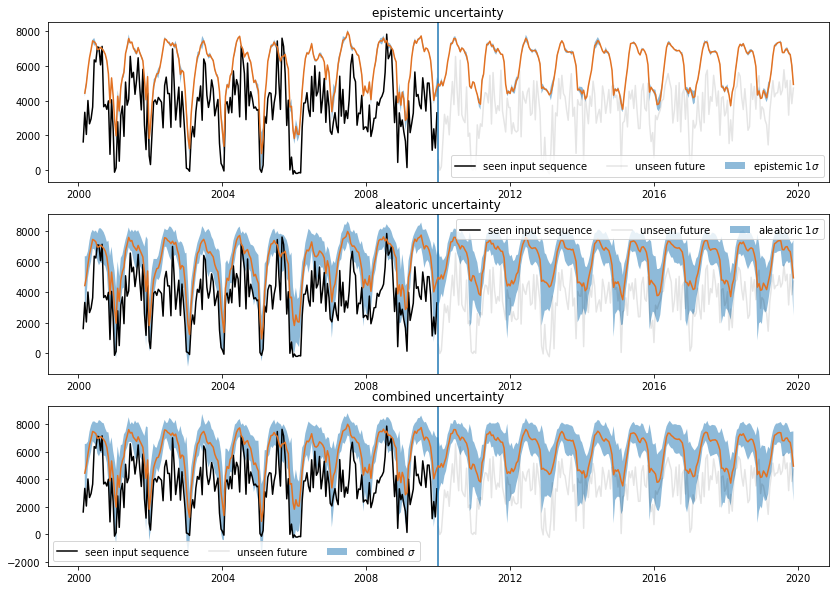

In [16]:
worst = results.sort_values(by="mse").iloc[-1].name
print(worst)
plot_example(worst,inner_steps=0)

130


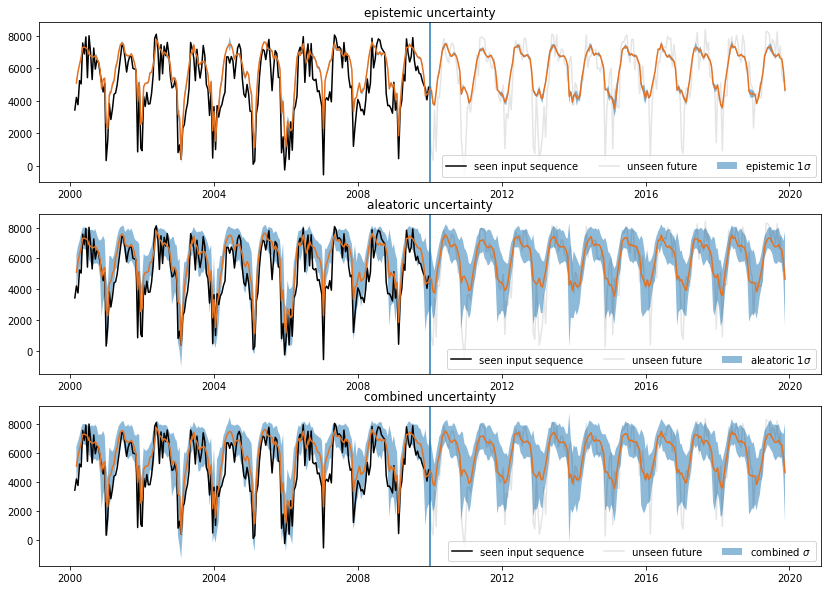

In [18]:
best = results.sort_values(by="mse").iloc[0].name
print(best)
plot_example(best,inner_steps=0)

/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


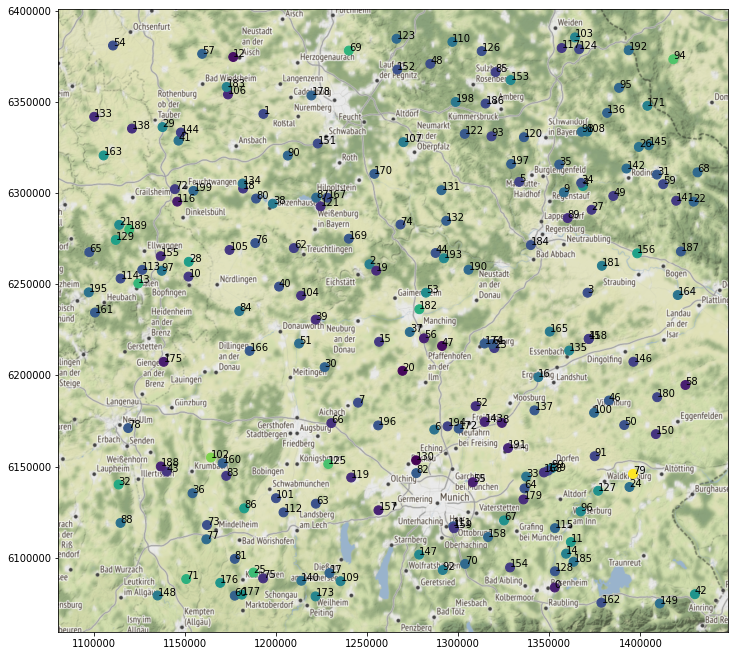

In [171]:
import geopandas as gpd
import contextily as ctx

gdf = gpd.GeoDataFrame(dataset.meta, geometry=gpd.points_from_xy(dataset.meta.x, dataset.meta.y),crs=4326).to_crs(epsg=3857)
gdf = pd.concat([gdf.reset_index(),results.reset_index()],axis=1)

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

    
fig,ax = plt.subplots(figsize=(12,12))
#gdf.plot(column="mse",ax=ax)
ax.scatter(gdf.geometry.x,gdf.geometry.y,c=gdf.mse,s=80)

for idx, row in gdf.iterrows():
    ax.annotate(s=f"{row.idx}", xy=(row.geometry.x,row.geometry.y))

url = "http://a.tile.stamen.com/terrain/tileZ/tileX/tileY.png"
add_basemap(ax,9,url)

In [159]:
gdf

,fid,x,y,fold,geometry,idx,mae,mse,r2,dtw
0,152,12.154,47.86,test,POINT (1352974.003 6083595.112),0,0.113583,0.024447,0.257133,20.566943
1,528,10.7171,49.4035,test,POINT (1193019.963 6343600.588),1,0.141060,0.032268,0.130231,25.963039
2,696,11.2402,48.9185,test,POINT (1251257.960 6261037.492),2,0.164234,0.044581,0.128188,29.620513
3,621,12.3157,48.8263,test,POINT (1370975.326 6245434.207),3,0.143586,0.033729,0.344160,26.963313
4,461,12.2928,49.1714,test,POINT (1368426.953 6304001.309),4,0.178678,0.050031,-0.074593,35.380187
...,...,...,...,...,...,...,...,...,...,...
195,835,9.85584,48.8275,test,POINT (1097147.187 6245650.173),195,0.164790,0.041709,-0.055683,28.938146
196,192,11.2831,48.3936,test,POINT (1256032.203 6172588.776),196,0.145978,0.034841,0.277967,26.750798
197,629,11.939,49.2425,test,POINT (1329042.964 6316111.946),197,0.157684,0.037166,0.253678,33.408731
198,559,11.6653,49.4418,test,POINT (1298573.955 6350167.769),198,0.158379,0.042995,0.327263,31.581872


In [164]:
results.mse.median()

0.036061051505980074

In [166]:
results.mse.mean()

0.037559246902153856